In [1]:
import matplotlib.pyplot as plt
import numpy as np



"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [2]:
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.special

import time
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

In [3]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [100]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import random, zeros

from numba import jit

dt = 0.0005 # Time step.
T = 25 # Total time.
n = int(T / dt) # Number of time steps.

times = np.linspace(0., T, n)


J=1
N=10
    

refdecay=0  #Gamma (solely)




refg=1
refgamma=0.25  #Gamma phi (for dephasing)
refkappa=0.5  #similar in the equation to decay
refomega=1


g_coef=refg*J
Gamma_phi=refgamma*J
kappa=refkappa*J
Omega=refomega*J


#------------------------------------------------------------------------------------

refchi=0    
Gamma_du=0  #Fixed
Gamma_decay=refdecay*J/N
chi=refchi*J


#------------------------------------------------------------------------------------


sqrt_2phi=  (2*Gamma_phi)**0.5
sqrt_decay= (Gamma_decay)**0.5
Stochastic=1   #Is the process stochastic?
sqrt_Gamma_phi = np.sqrt(Gamma_phi)

gama_sq= (  ((2*Gamma_phi)**0.5+ (Gamma_decay)**0.5  )**2 )/2

sqrt_N=np.sqrt(N)


theta = 0  #Initial state
phi   = 0



#set the initial values due to the measurements in the state |\psi>=cos(\theta/2)|0>+sin(\theta/2)|1>

from scipy import stats
mk = np.array([-1,1])


xp= (0.5*(1-np.sin(theta)*np.cos(phi)),0.5*(1+np.sin(theta)*np.cos(phi)))
yp= (0.5*(1-np.sin(theta)*np.sin(phi)),0.5*(1+np.sin(theta)*np.sin(phi)))
zp = ((np.cos(theta/2))**2, (np.sin(theta/2))**2)


custmx = stats.rv_discrete(name='custmx', values=(mk, xp))
custmy = stats.rv_discrete(name='custmy', values=(mk, yp))
custmz = stats.rv_discrete(name='custmz', values=(mk, zp))



#Initial value coherent state

alpha_x=0
alpha_y=0

mean = [0, 0]
cov = [[1/2, 0], [0, 1/2]]  # diagonal covariance
NV_bivariate = np.random.multivariate_normal(mean, cov, 1).T

alpha_x_init=NV_bivariate[0][0]
alpha_y_init=NV_bivariate[1][0]




@jit

def trayectory(N=N):
    sqrtdt = np.sqrt(dt)*Stochastic
    
    Results =zeros((3*N+2, n))

    for j in range(N):
        
        
        a=custmx.rvs()
        b=custmy.rvs()
        c=custmz.rvs()
        
        Results[j][0]    =a  
        Results[j+N][0]  =b
        Results[j+2*N][0]=c
        
    Results[3*N][0]  =alpha_x_init
    Results[3*N+1][0]=alpha_y_init
    
    for t in range(n-1):
 
        Normal_VA_1=random.randn() #np.random.normal(0, 1)
        Normal_VA_2=random.randn() #np.random.normal(0, 1)
        
        Results[3*N][t+1]   = -kappa*Results[3*N][t]*dt+np.sqrt(kappa/2)*sqrtdt * Normal_VA_1
        Results[3*N+1][t+1] = -kappa*Results[3*N+1][t]*dt+np.sqrt(kappa/2)*sqrtdt * Normal_VA_2
        
        for i in range(N): 
            
            Normal_VA=random.randn() #np.random.normal(0, 1) #Local noise, inside the indexer i
            
            Results[i][t+1]     = Results[i][t]+dt*(-2*g_coef/np.sqrt(N))*Results[3*N+1][t]*Results[i+2*N][t]-\
                dt*Gamma_phi*Results[i][t]-sqrt_2phi*Results[i+N][t]* sqrtdt * Normal_VA
            
            Results[i+N][t+1]   = Results[i+N][t]+dt*(-2*g_coef/np.sqrt(N))*Results[3*N][t]*Results[i+2*N][t]-\
                dt*Omega*Results[i+2*N][t]-dt*Gamma_phi*Results[i+N][t]+sqrt_2phi*Results[i][t]* sqrtdt * Normal_VA
            
            Results[i+2*N][t+1] = Results[i+2*N][t]+dt*Omega*Results[i+N][t]+\
                dt*(2*g_coef/np.sqrt(N))*(Results[3*N][t]*Results[i+N][t]+Results[3*N+1][t]*Results[i][t])
                
            for j in range(N):
                
                Results[3*N][t+1]   = Results[3*N][t+1]   -(g_coef/(2*np.sqrt(N)))*Results[j+N][t] *dt
                Results[3*N+1][t+1] = Results[3*N+1][t+1] -(g_coef/(2*np.sqrt(N)))*Results[j][t] *dt

    return Results


In [101]:
from numpy import mean
from numpy import linalg

from numba import jit
@jit

def summary_stat(Res,N=N,n=n):
    Results =zeros((9, n))
    count=0
    while count<n:
        a,b,c=Res[0:N, count:count+1],Res[N:2*N, count:count+1],Res[2*N:3*N, count:count+1]
        
        Results[0][count],Results[1][count],Results[2][count]=N*mean(a)/2,N*mean(b)/2,N*mean(c)/2
        Results[3][count]=0.25*(  (N*mean(a))**2- (linalg.norm(a,2))**2 )
        Results[4][count]=0.25*(  (N*mean(b))**2- (linalg.norm(b,2))**2 )
        Results[5][count]=0.25*(  (N*mean(c))**2- (linalg.norm(c,2))**2 )
        Results[6][count]=(N*mean(a)/2)**2
        Results[7][count]=(N*mean(b)/2)**2
        Results[8][count]=(N*mean(c)/2)**2
        
        
        count=count+1
        
    
    return Results

In [102]:
from numpy import add
from numba import jit



itera=5000
@jit

def averages(itera=itera,N=N,n=n,Stochastic=Stochastic):
    Results =zeros((9, n))
    for j in range(itera):
        Trayec=trayectory(N=N)
        Results=add(Results,summary_stat(Trayec,N,n))
    
    return Results/itera
    
    
    
    

In [103]:
t0=time.time()

itera=2500

Result_varDDTWA_EM=averages(itera=itera,N=N,n=n,Stochastic=1)
#Result_varDTWA=averages(itera=itera,N=N,n=n,Stochastic=0)

t1=time.time()

print(t1-t0)



<ipython-input-102-eb11f0cbbd04>:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "averages" failed type inference due to: Invalid use of type(CPUDispatcher(<function trayectory at 0x000002084ACADEE0>)) with parameters (N=int64)

During: resolving callee type: type(CPUDispatcher(<function trayectory at 0x000002084ACADEE0>))
During: typing of call at <ipython-input-102-eb11f0cbbd04> (12)


File "<ipython-input-102-eb11f0cbbd04>", line 12:
def averages(itera=itera,N=N,n=n,Stochastic=Stochastic):
    <source elided>
    for j in range(itera):
        Trayec=trayectory(N=N)
        ^

  @jit
<ipython-input-102-eb11f0cbbd04>:7: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "averages" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-102-eb11f0cbbd04>", line 11:
def averages(itera=itera,N=N,n=n,Stochastic=St

961.0957403182983


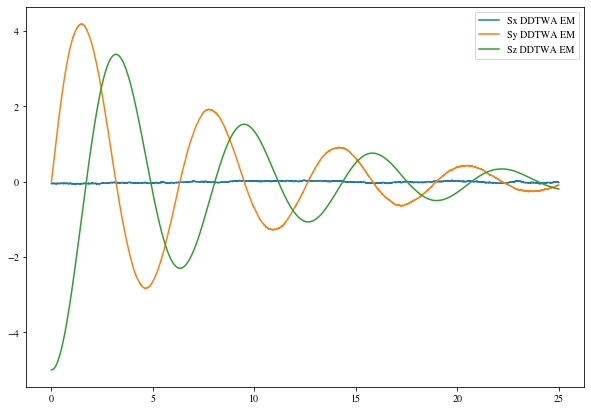

In [104]:

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

plt.plot(times, Result_varDDTWA_EM[0],"-",label="Sx DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[1],"-",label="Sy DDTWA EM")

plt.plot(times, Result_varDDTWA_EM[2],"-",label="Sz DDTWA EM")


plt.legend()

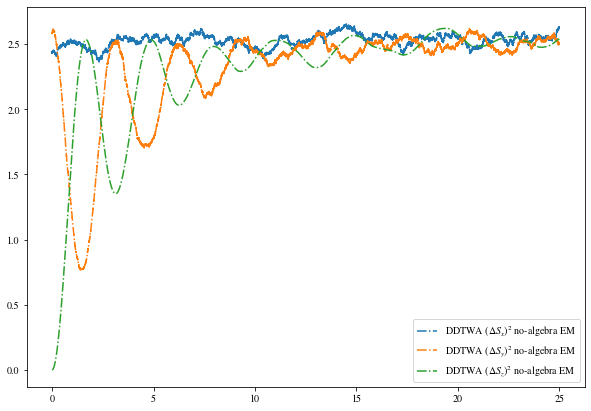

In [105]:



matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

axEM=N/4+  Result_varDDTWA_EM[3+0]-(Result_varDDTWA_EM[0])**2
ayEM=N/4+  Result_varDDTWA_EM[3+1]-(Result_varDDTWA_EM[1])**2
azEM=N/4+  Result_varDDTWA_EM[3+2]-(Result_varDDTWA_EM[2])**2


ax1EM=np.array(Result_varDDTWA_EM[6+0])-np.array((Result_varDDTWA_EM[0])**2)
ay1EM=np.array(Result_varDDTWA_EM[6+1])-np.array((Result_varDDTWA_EM[1])**2)
az1EM=np.array(Result_varDDTWA_EM[6+2])-np.array((Result_varDDTWA_EM[2])**2)



#axSH=N/4+  Result_varDDTWA_SH[3+0]-(Result_varDDTWA_SH[0])**2
#aySH=N/4+  Result_varDDTWA_SH[3+1]-(Result_varDDTWA_SH[1])**2
#azSH=N/4+  Result_varDDTWA_SH[3+2]-(Result_varDDTWA_SH[2])**2


#ax1SH=np.array(Result_varDDTWA_SH[6+0])-np.array((Result_varDDTWA_SH[0])**2)
#ay1SH=np.array(Result_varDDTWA_SH[6+1])-np.array((Result_varDDTWA_SH[1])**2)
#az1SH=np.array(Result_varDDTWA_SH[6+2])-np.array((Result_varDDTWA_SH[2])**2)



#plt.plot(times,axEM,"--",label="DDTWA $(\Delta S_x)^2$ EM")
#plt.plot(times,ayEM,"--",label="DDTWA $(\Delta S_y)^2$ EM")
#plt.plot(times,azEM,"--",label="DDTWA $(\Delta S_z)^2$ EM")

plt.plot(times,ax1EM,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra EM")
plt.plot(times,ay1EM,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra EM")
plt.plot(times,az1EM,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra EM")


#plt.plot(times,axSH,"--",label="DDTWA $(\Delta S_x)^2$ SH")
#plt.plot(times,aySH,"--",label="DDTWA $(\Delta S_y)^2$ SH")
#plt.plot(times,azSH,"--",label="DDTWA $(\Delta S_z)^2$ SH")

#plt.plot(times,ax1SH,"-.",label="DDTWA $(\Delta S_x)^2 $ no-algebra SH")
#plt.plot(times,ay1SH,"-.",label="DDTWA $(\Delta S_y)^2 $ no-algebra SH")
#plt.plot(times,az1SH,"-.",label="DDTWA $(\Delta S_z)^2 $ no-algebra SH")


#plt.plot(times,np.real(np.array(Sxx_result))-(np.array(Sx_result))**2,label="xx")
#plt.plot(times,np.real(np.array(Syy_result))-(np.array(Sy_result))**2,label="yy")
#plt.plot(times,np.real(np.array(Szz_result))-(np.array(Sz_result))**2,label="zz")

plt.legend()




plt.legend(loc="lower right")

In [32]:
import matplotlib.pyplot as plt
alpha_x=0
alpha_y=0

mean = [alpha_x, alpha_y]
cov = [[1/2, 0], [0, 1/2]]  # diagonal covariance
NV_bivariate = np.random.multivariate_normal(mean, cov, 1).T

alpha_x_init=NV_bivariate[0][0]
alpha_y_init=NV_bivariate[1][0]

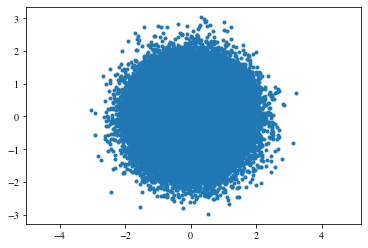

In [35]:
mean = [0, 0]
cov = [[1/2, 0], [0, 1/2]]  # diagonal covariance

import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 100000).T
plt.plot(x, y, '.')
plt.axis('equal')
plt.show()